<a href="https://colab.research.google.com/github/PaulFroehling/Neural-Style-Transfer/blob/main/Layer_Based_Mixed_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

The total loss is defined by the the style loss and the content loss: I.e. the distance of the optimized/modified content image to the original content image and the the style image. 
While the content loss is calculated by the output of a later layer (outputting complex features), the style is heavily influenced by earlier layers, elaborating more simple features.

In [186]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1','block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']
layer_names = content_layers + style_layers

no_style_layers = len(style_layers)
no_content_layers = len(content_layers)

style_weight_1 = 0.02 * 0.55
style_weight_2 = 0.02 * 1.0
style_weights = [style_weight_1, style_weight_2]

layer_style_weights_1= [1.0, 1.0, 1.0, 1.0, 1.0]
layer_style_weights_2= [1.0, 1.0, 1.0, 1.0, 1.0]

content_weight = 0.02
total_variation_weight = 20

In [136]:
IMAGE_DIR = '/content/images'
!mkdir {IMAGE_DIR}

contentimg_path = '/content/images/image.jpeg'
styleimg_1_path = '/content/images/style_2.jpg'
styleimg_2_path = '/content/images/wave.jpg'
styleimg_paths = [styleimg_1_path, styleimg_2_path] 
!ls images

mkdir: cannot create directory ‘/content/images’: File exists
doggy.png      image.jpeg  output_Y5BPgc8NNbG0_0.png  style_2.jpg
generated.jpg  image.png   sky.jpg		      wave.jpg


In [177]:
def vgg_model(layer_names):
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
  vgg.trainable=False
  outputs=[vgg.get_layer(name).output for name in layer_names]
  model=tf.keras.Model(inputs=vgg.input, outputs=outputs)

  return model


def calc_gram_matrix(input):

  reshaped_input = tf.reshape(input,[input.shape[0]*input.shape[1]*input.shape[2], input.shape[-1]])
  reshaped_input_transposed = tf.transpose(reshaped_input)

  #Compute the dot product of the reshaped input with itself
  gram_matrix = tf.matmul(reshaped_input_transposed, reshaped_input)

  return gram_matrix
   
def prep_imgs(img):
  #Center distribution of pixel values to 0. Required when feeding images to vgg19
  img = tf.cast(img, dtype=tf.float32)
  img =tf.keras.applications.vgg19.preprocess_input(img)
  #img = tf.image.resize(img, (224, 224))
  return img


def load_img(path_to_img):
  '''loads an image as a tensor and scales it to 512 pixels'''
  max_dim = 728
  image = tf.io.read_file(path_to_img)
  image = tf.image.decode_jpeg(image)
  image = tf.image.convert_image_dtype(image, tf.float32)

  shape = tf.shape(image)[:-1]
  shape = tf.cast(tf.shape(image)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  image = tf.image.resize(image, new_shape)
  image = image[tf.newaxis, :]
  image = tf.image.convert_image_dtype(image, tf.uint8)

  return image

def load_content_and_style_images(content_image_path, style_image_paths):
  style_imgs = []
  for style_path in style_image_paths:
    style_imgs.append(load_img(style_path))

  content_img = load_img(contentimg_path)
  return content_img, style_imgs


def tensor_to_image(tensor):
  tensor_shape = tf.shape(tensor)
  number_elem_shape = tf.shape(tensor_shape)
  if number_elem_shape > 3:
    assert tensor_shape[0] == 1
    tensor = tensor[0]
  return tf.keras.preprocessing.image.array_to_img(tensor) 

def clip_image_values(image, min_value=0.0, max_value=255.0):
  return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)



def calc_style_loss(ft, tgt):
  return 0.5*tf.reduce_mean(tf.square(ft - tgt))

def calc_content_loss(ft, tgt):
  return 0.5 * tf.reduce_sum(tf.square(ft - tgt))

def calc_style_content_loss(style_targets, gen_style_features, content_targets, gen_content_features, style_weights, content_weight,layer_style_weights_1,layer_style_weights_2):
 
  style_loss_1 = tf.add_n([weight * calc_style_loss(gen_style, style_target) for gen_style, style_target, weight in zip(gen_style_features, style_targets[0], layer_style_weights_1)])
  style_loss_1 *= style_weights[0] / no_style_layers

  style_loss_2 = tf.add_n([weight * calc_style_loss(gen_style, style_target) for gen_style, style_target, weight in zip(gen_style_features, style_targets[1], layer_style_weights_2)])
  style_loss_2 *= style_weights[1] / no_style_layers

  style_loss = style_loss_1 + style_loss_2

  content_loss = tf.add_n([calc_content_loss(gen_content_features, content_target) for gen_content_features, content_target in zip(gen_content_features, content_targets)])
  content_loss *= content_weight / no_content_layers

  return style_loss + content_loss


def get_style_image_features(img):
  preprocessed_style_image = prep_imgs(img) 
  outputs = vgg(preprocessed_style_image) 
  style_outputs = outputs[:no_style_layers] 
  gram_style_feature = [calc_gram_matrix(style_layer) for style_layer in style_outputs]

  return gram_style_feature

def get_content_image_features(img):
  prep_content_img = prep_imgs(img)
  content_outputs = vgg(prep_content_img)
  return content_outputs[no_style_layers:]


def calc_gradients(generated_image, style_targets, content_targets,
                   style_weights, content_weight, layer_style_weights_1, layer_style_weights_2):
  
  with tf.GradientTape() as tape:
    #calc style and content features for generated image
    gen_style_features = get_style_image_features(generated_image)
    gen_content_features = get_content_image_features(generated_image)
    loss=calc_style_content_loss(style_targets, gen_style_features, content_targets, gen_content_features, style_weights, content_weight, layer_style_weights_1, layer_style_weights_2)
    #loss += var_weight + tf.image.total_variation(generated_image)
    gradients = tape.gradient(loss, generated_image)

    return gradients


def update_image_with_style(generated_image, style_targets, content_targets, style_weights,
                            content_weight, optimizer, layer_style_weights_1, layer_style_weights_2):

  gradients = calc_gradients(generated_image, style_targets, content_targets, 
                                  style_weights, content_weight, layer_style_weights_1, layer_style_weights_2) 
  

  optimizer.apply_gradients([(gradients, generated_image)]) 
  
  generated_image.assign(clip_image_values(generated_image, min_value=0.0, max_value=255.0))


def optimize_image(style_images, content_image, style_weights, layer_style_weights_1, layer_style_weights_2, content_weight,
                   optimizer='adam', epochs=1, steps_per_epoch=1):
  
  generated_images = []


  generated_image = tf.cast(content_image, dtype=tf.float32)
  generated_image = tf.Variable(generated_image)
  generated_images.append(content_image)
  style_targets_1 = get_style_image_features(style_images[0])
  style_targets_2 = get_style_image_features(style_images[1])
  style_targets = [style_targets_1, style_targets_2]


  content_targets = get_content_image_features(content_image)
  for i in range(0, epochs):
    for j in range(0, steps_per_epoch):

      update_image_with_style(generated_image, style_targets, content_targets, 
                              style_weights, content_weight , optimizer, layer_style_weights_1, layer_style_weights_2) 
    
      
      if j%50==0: 
        generated_images.append(generated_image)
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        print("Epoch: "+str(i)+" Step: "+str(j))

  return generated_images
    

Content image on the left, style image on the right

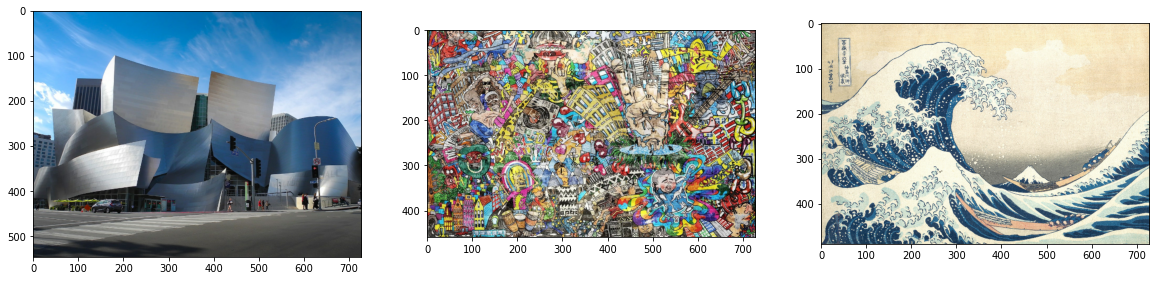

In [166]:
content_img, style_imgs = load_content_and_style_images(contentimg_path, styleimg_paths)
images_plot = [content_img, style_imgs[0], style_imgs[1]]
plt.figure(figsize=(20, 7))
for i in range(0, 3):
  plt.subplot(1,3, i+1)
  plt.imshow(images_plot[i][0])

In [140]:
tf.keras.backend.clear_session()

vgg = vgg_model(layer_names)

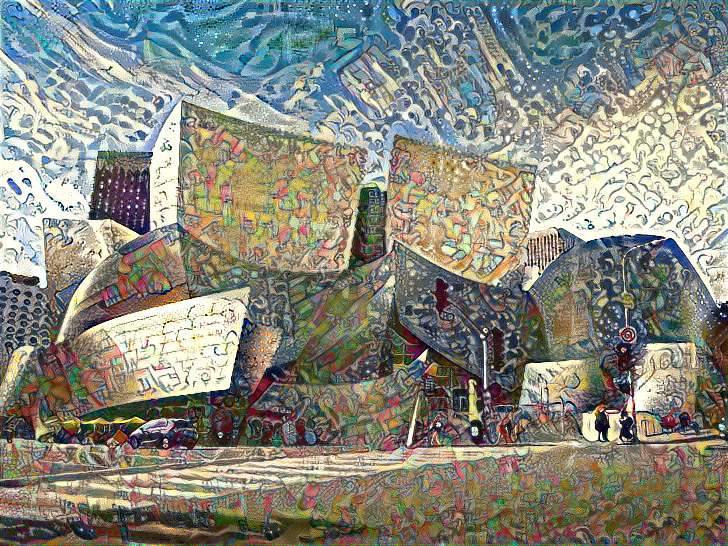

Epoch: 0 Step: 100


In [190]:
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=16.0, decay_steps=100, decay_rate=0.6
    )
)

stylized_images = optimize_image(style_imgs, content_img, style_weights, layer_style_weights_1, layer_style_weights_2, content_weight, optimizer=adam, epochs=1, steps_per_epoch=150)
